## Introduction


Pneumonia diagnosis is tedious and time-consuming.

chest X-rays are examined by trained radiologists in order to diagnose the disease. 

A model for the identification of pneumonia, trained on chest X-ray images, has been proposed in this project

## Data Pre-Processing

In [ ]:
!pip install opencv-python
!pip install tensorflow

In [ ]:
#Import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout,AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#data stored in the local drive
main_dirction_path = 'chest_xray'
print(os.listdir(main_dirction_path))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [ ]:
os.getcwd()

'D:\\YEAR 4 (Honours)\\SEM 2\\CM4126 - Computer Vision'

In [ ]:
# path for train/ test and validate folders
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'
val_folder_path = main_dirction_path + '/val/'

In [ ]:
labels = os.listdir(train_folder_path)
img_size = 128
labels

['NORMAL', 'PNEUMONIA']

In [ ]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

In [ ]:
print(f'Number of normal images (negative results) is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of postive images (positive results) is {len(os.listdir(train_p_path))}') #length of pneumonia training images

print(f'Total numbdr of training images is {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')


Number of normal images (negative results) is 1341
Number of postive images (positive results) is 3875
Total numbdr of training images is 5216


In [ ]:
#Function to read in the different training datasets
def get_training_data(data_dir):
    data = []
    
    #count = 0
    #targetnumOfPos = len(os.listdir(train_n_path) * 0.4)
    #targetnumOfNeg = len(os.listdir(train_p_path) * 0.4)

    for label in labels:     
        #if count == targetnumOfPos:
          #continue
          path = os.path.join(data_dir, label)
          class_num = labels.index(label)
          
          for img in os.listdir(path):
              try:
                  img_arr = cv2.imread(os.path.join(path, img))
                  resized_arr = cv2.resize(img_arr, (img_size, img_size)) #Reshaping images to preferred size
                  data.append([resized_arr, class_num])
              except Exception as e:
                  print(e)
    return np.array(data)

In [ ]:
# Load the datasets
train = get_training_data(train_folder_path)
test = get_training_data(test_folder_path)
val = get_training_data(val_folder_path)


In [ ]:
print(f'The shape of the training set is {train.shape}')

The shape of the training set is (5216, 2)


In [ ]:
#import random
#np.random.shuffle(train)
#np.random.shuffle(test)
#np.random.shuffle(val)


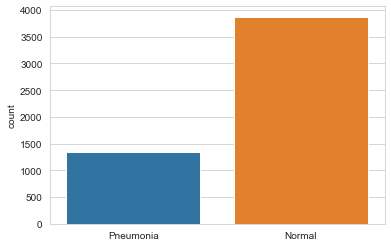

In [ ]:
l = []

for i in train:
  if(i[1] == 0):
    l.append("Pneumonia")
  else:
    l.append("Normal")

sns.set_style('whitegrid')
sns.countplot(l)


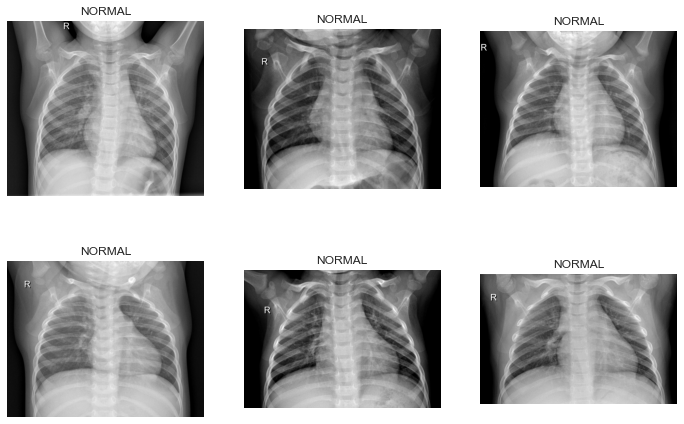

In [ ]:
def show_sample_images (number, normal=True):
    plt.figure(figsize=(12,12))
    if normal == True:
        for n in range(number):
            normal_img = os.listdir(train_n_path)[n]
            normal_img_address = train_n_path+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(number/2,number/2,n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("NORMAL")
            plt.axis("off")
    else:
        for n in range(number):
            pneumonia_img = os.listdir(train_p_path)[n]
            pneumonia_img_address = train_p_path+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            ax = plt.subplot(number/2,number/2,n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("PNEUMONIA")
            plt.axis("off")

# Show normal images
show_sample_images(6)


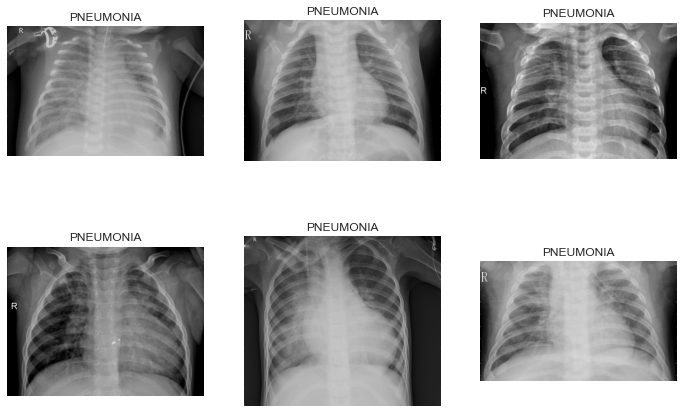

In [ ]:
# Show pneumonia images
show_sample_images(6, False)

In [ ]:
from skimage import exposure

In [ ]:
#Function to create histogram
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [ ]:
def expose_image (Normal = True):
  if Normal == True:

    random_img_ind = np.random.randint(0, len(os.listdir(train_n_path)))

    #image file name
    img_expose_name = os.listdir(train_n_path)[random_img_ind]

    # path to the image
    img_expose_address = train_n_path+img_expose_name

    # load mage
    img_expose = Image.open(img_expose_address)
    img = np.asarray(img_expose)
    image_eq = equlize_hist_(img)
    figure1 = plt.figure(figsize= (16,16))
    img_1 = figure1.add_subplot(1,2,1)
    img_plot = plt.imshow(img, cmap = 'gray')
    img_1.set_title('Normal')
    plt.axis("off")
    img2 = figure1.add_subplot(1, 2, 2)
    img_plot = plt.imshow(image_eq, cmap = 'gray')
    img2.set_title('Normal after HE')
    plt.axis("off")
  else:
    # Choose normal random image: generate random number between 1 and the number of normal images in the training set
    random_img_ind= np.random.randint(0,len(os.listdir(train_p_path)))
    # image file name
    img_expose_name = os.listdir(train_p_path)[random_img_ind]

    # path to the image
    img_expose_address = train_p_path+img_expose_name
    # load mage
    img_expose = Image.open(img_expose_address)
    img = np.asarray(img_expose)
    image_eq = equlize_hist_(img)
    figure1 = plt.figure(figsize= (16,16))
    img_1 = figure1.add_subplot(1,2,1)
    img_plot = plt.imshow(img, cmap = 'gray')
    img_1.set_title('Pneumonia')
    plt.axis("off")
    img2 = figure1.add_subplot(1, 2, 2)
    img_plot = plt.imshow(image_eq, cmap = 'gray')
    img2.set_title('Pneumonia after HE')
    plt.axis("off")
    

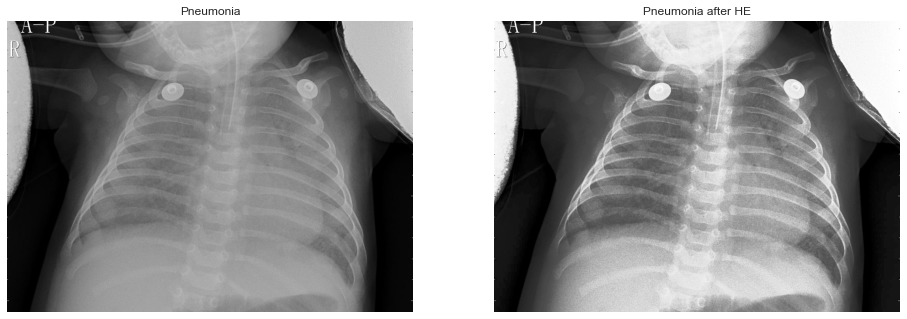

In [ ]:
# expose_image() will show random normal image
expose_image(False)


## Build CNN

In [ ]:
#Training data
x_train = []
y_train = []

#Value data
x_val = []
y_val = []

#Test Data
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


In [ ]:
y_train, y_val, x_train, x_val = train_test_split(y_train, x_train, test_size = 0.2, stratify = y_train)


In [ ]:
print(f'Number of images in the training set is {len(x_train)}')
print(f'Number of images in the val set is {len(x_val)}')
print(f'Number of images in the test set is {len(x_test)}')

Number of images in the training set is 4172
Number of images in the val set is 1044
Number of images in the test set is 624


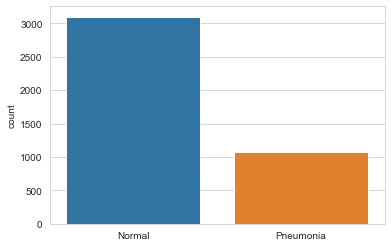

In [ ]:
l = []

for j in y_train:
  if(j == 0):
    l.append("Pneumonia")
  else:
    l.append("Normal")

sns.set_style('whitegrid')
sns.countplot(l)

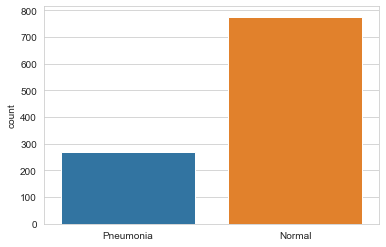

In [ ]:
l = []

for j in y_val:
  if(j == 0):
    l.append("Pneumonia")
  else:
    l.append("Normal")

sns.set_style('whitegrid')
sns.countplot(l)

In [ ]:
#Normalise the data
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
#Resize the data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#n_steps = int(math.ceil(1. * training_set.samples / batch_size))
#Data generator
datagen = ImageDataGenerator(
    #rescale = 1.0/255,
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset


    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range = 30, # randomly rotate images in the range (degrees, 0 to 180)

    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)

    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)

    horizontal_flip = True, # randomly flip images
    vertical_flip=False) # randomly flip images

datagen.fit(x_train)


In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation ='relu' ,
input_shape = (img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation ='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation ='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation ='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics =['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [ ]:
total = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
neg = len(os.listdir(train_n_path))
pos = len(os.listdir(train_p_path))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight


{0: 1.9448173005219984, 1: 0.6730322580645162}

## Training Base Model

In [ ]:
batch_size = 32
n_epochs = 25

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
epochs = n_epochs , validation_data = datagen.flow(x_val,y_val) ,
callbacks = [learning_rate_reduction],
class_weight = class_weight)


Epoch 1/25
131/131 [==============================] - 56s 416ms/step - loss: 0.6858 - accuracy: 0.8123 - val_loss: 9.9661 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 54s 413ms/step - loss: 0.3398 - accuracy: 0.8672 - val_loss: 25.9805 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8873
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 53s 408ms/step - loss: 0.3161 - accuracy: 0.8873 - val_loss: 14.9801 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 53s 406ms/step - loss: 0.1865 - accuracy: 0.9310 - val_loss: 4.1782 - val_accuracy: 0.7462 - lr: 3.0000e-04
Epoch 5/25
131/131 [==============================] - 53s 402ms/step - loss: 0.1572 - accuracy: 0.9458 - val_loss: 0.4429 - val_accuracy: 0.8305 - lr: 3.0000e-04
Epoch 6/25
131/131 [===================

## Results from trained base model

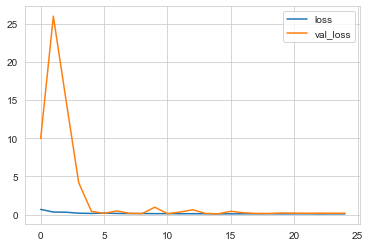

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()


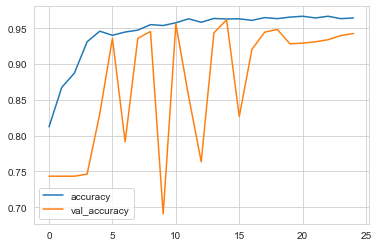

In [ ]:
losses[['accuracy','val_accuracy']].plot()


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 68ms/step - loss: 0.3737 - accuracy: 0.8622
Loss of the model is -  0.37372490763664246
20/20 [==============================] - 1s 68ms/step - loss: 0.3737 - accuracy: 0.8622
Accuracy of the model is -  86.21794581413269 %


In [ ]:
from tensorflow.keras.models import load_model
model.save('CNN_PNEUMONIA.h5') 
#cnn_model = load_model("./CNN_PNEUMONIA.h5")
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = np.round(predictions, 0)
print(predictions)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.76      0.93      0.83       234
   Normal (Class 1)       0.95      0.82      0.88       390

           accuracy                           0.86       624
          macro avg       0.85      0.88      0.86       624
       weighted avg       0.88      0.86      0.86       624



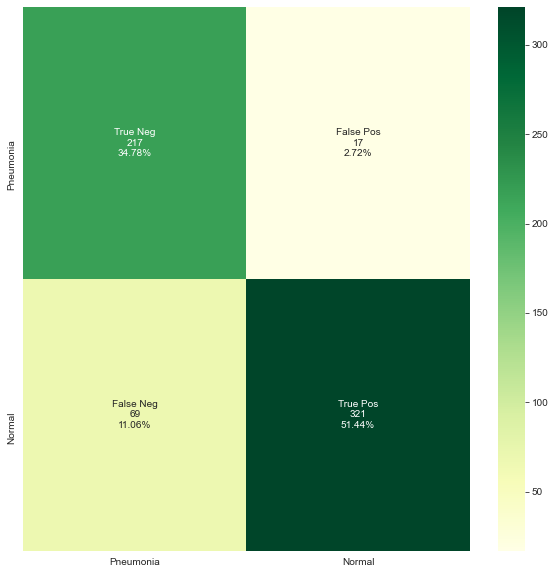

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) 

    for value in
      cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) 
    for value in
      cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
xticklabels = classes,yticklabels = classes)


In [ ]:
# store actual class labels and predicted ones in a dataframe
results = pd.DataFrame({'Actual':y_test,'Predicted':predictions})
incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
16,0,1.0
119,0,1.0
120,0,1.0
121,0,1.0
122,0,1.0


In [ ]:
# manual calculation of of results
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')


Accuracy is 86.0 %


In [ ]:
#show some examples
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]


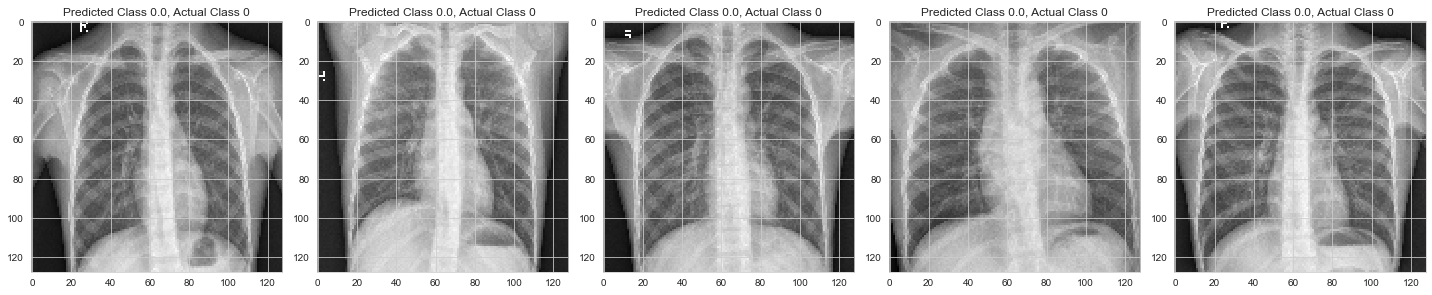

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1


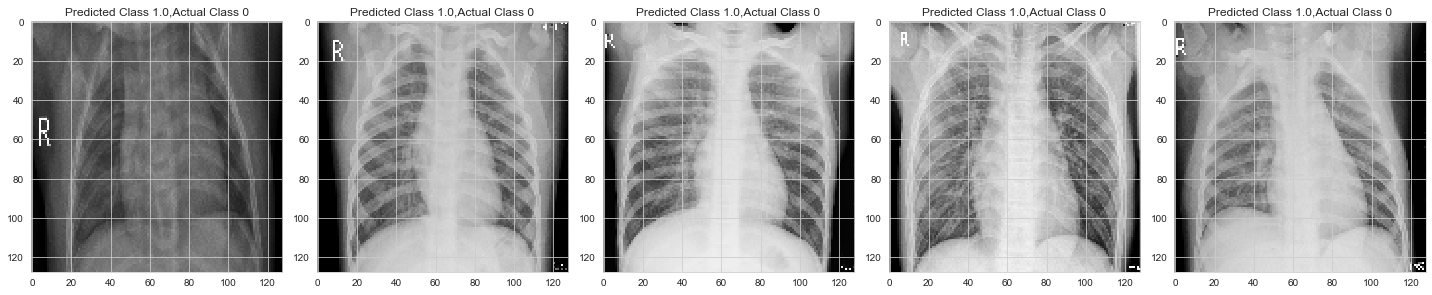

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1


## Transfer Learning using ResNet152V2

In [ ]:
from keras.applications.vgg16 import VGG16 #(if you want to use VG16)
from keras.applications.inception_v3 import InceptionV3

In [ ]:
# Notice 1st time this is being run, it will download the weights for the ResNetmodel
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False


In [ ]:
def get_pretrained():
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    x = base_model(inputs)
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy',
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
metrics='binary_accuracy')
model_pretrained.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,

epochs = n_epochs , validation_data = datagen.flow(x_val,y_val),
callbacks = [learning_rate_reduction],
steps_per_epoch = x_train.shape[0]/batch_size,
class_weight = class_weight)


Epoch 1/25
130/130 [==============================] - 138s 1s/step - loss: 0.4620 - binary_accuracy: 0.7740 - val_loss: 0.3223 - val_binary_accuracy: 0.8688 - lr: 5.0000e-05
Epoch 2/25
130/130 [==============================] - 130s 995ms/step - loss: 0.2968 - binary_accuracy: 0.8725 - val_loss: 0.2311 - val_binary_accuracy: 0.9090 - lr: 5.0000e-05
Epoch 3/25
130/130 [==============================] - 130s 998ms/step - loss: 0.2633 - binary_accuracy: 0.8931 - val_loss: 0.2506 - val_binary_accuracy: 0.8879 - lr: 5.0000e-05
Epoch 4/25
130/130 [==============================] - 130s 999ms/step - loss: 0.2574 - binary_accuracy: 0.8873 - val_loss: 0.2344 - val_binary_accuracy: 0.9052 - lr: 5.0000e-05
Epoch 5/25
130/130 [==============================] - 130s 998ms/step - loss: 0.2273 - binary_accuracy: 0.9053 - val_loss: 0.2344 - val_binary_accuracy: 0.9061 - lr: 5.0000e-05
Epoch 6/25
130/130 [==============================] - 130s 997ms/step - loss: 0.2190 - binary_accuracy: 0.9104 - val_l

130/130 [==============================] - 129s 993ms/step - loss: 0.1907 - binary_accuracy: 0.9240 - val_loss: 0.1486 - val_binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 20/25
130/130 [==============================] - 129s 991ms/step - loss: 0.1792 - binary_accuracy: 0.9267 - val_loss: 0.1996 - val_binary_accuracy: 0.9234 - lr: 5.0000e-05
Epoch 21/25
130/130 [==============================] - 129s 992ms/step - loss: 0.1759 - binary_accuracy: 0.9291 - val_loss: 0.1775 - val_binary_accuracy: 0.9349 - lr: 5.0000e-05
Epoch 22/25
130/130 [==============================] - 130s 999ms/step - loss: 0.1759 - binary_accuracy: 0.9267 - val_loss: 0.1561 - val_binary_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 23/25
130/130 [==============================] - 129s 991ms/step - loss: 0.1799 - binary_accuracy: 0.9255 - val_loss: 0.1754 - val_binary_accuracy: 0.9339 - lr: 5.0000e-05
Epoch 24/25
130/130 [==============================] - 129s 991ms/step - loss: 0.1648 - binary_accuracy: 0.9377 - val_loss

## Results for ResNet152V2

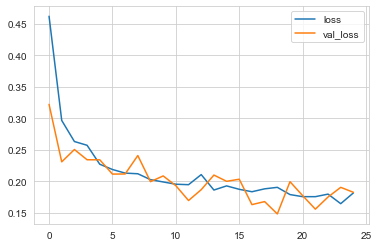

In [ ]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

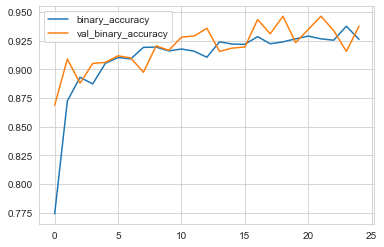

In [ ]:
losses[['binary_accuracy','val_binary_accuracy']].plot()


In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 17s 766ms/step - loss: 0.3080 - binary_accuracy: 0.8814
Loss of the model is -  0.30803200602531433
20/20 [==============================] - 15s 764ms/step - loss: 0.3080 - binary_accuracy: 0.8814
Accuracy of the model is -  88.14102411270142 %


In [ ]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

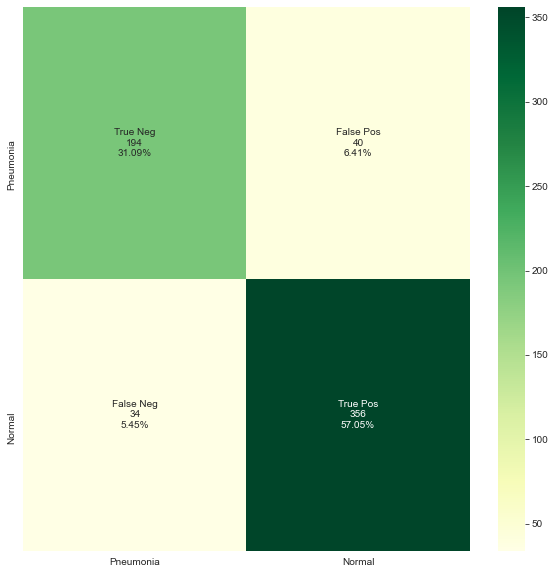

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value)for value in
cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
xticklabels = classes,yticklabels = classes)


In [ ]:
cf_matrix

array([[194,  40],
       [ 34, 356]], dtype=int64)

## Fine Tuning ResNet152V2

In [ ]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [ ]:
model_pretrained.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002),
                         metrics='binary_accuracy')

model_pretrained.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size),
epochs = n_epochs, validation_data = datagen.flow(x_val,y_val),
callbacks = [learning_rate_reduction],
steps_per_epoch = x_train.shape[0]/batch_size,
class_weight = class_weight)


Epoch 1/25
130/130 [==============================] - 164s 1s/step - loss: 0.2784 - binary_accuracy: 0.9118 - val_loss: 0.2570 - val_binary_accuracy: 0.9033 - lr: 2.0000e-06
Epoch 2/25
130/130 [==============================] - 155s 1s/step - loss: 0.2455 - binary_accuracy: 0.9063 - val_loss: 0.2380 - val_binary_accuracy: 0.9100 - lr: 2.0000e-06
Epoch 3/25
130/130 [==============================] - 155s 1s/step - loss: 0.2343 - binary_accuracy: 0.9106 - val_loss: 0.2447 - val_binary_accuracy: 0.9157 - lr: 2.0000e-06
Epoch 4/25
130/130 [==============================] - 155s 1s/step - loss: 0.2322 - binary_accuracy: 0.9108 - val_loss: 0.2313 - val_binary_accuracy: 0.9215 - lr: 2.0000e-06
Epoch 5/25
130/130 [==============================] - 155s 1s/step - loss: 0.2247 - binary_accuracy: 0.9065 - val_loss: 0.2161 - val_binary_accuracy: 0.9148 - lr: 2.0000e-06
Epoch 6/25
130/130 [==============================] - 155s 1s/step - loss: 0.2131 - binary_accuracy: 0.9173 - val_loss: 0.2149 - v

130/130 [==============================] - 141s 1s/step - loss: 0.1768 - binary_accuracy: 0.9305 - val_loss: 0.1987 - val_binary_accuracy: 0.9224 - lr: 2.0000e-06
Epoch 20/25
130/130 [==============================] - 141s 1s/step - loss: 0.1870 - binary_accuracy: 0.9252 - val_loss: 0.1732 - val_binary_accuracy: 0.9349 - lr: 2.0000e-06
Epoch 21/25
130/130 [==============================] - 141s 1s/step - loss: 0.1841 - binary_accuracy: 0.9286 - val_loss: 0.1750 - val_binary_accuracy: 0.9358 - lr: 2.0000e-06
Epoch 22/25
130/130 [==============================] - 141s 1s/step - loss: 0.1738 - binary_accuracy: 0.9322 - val_loss: 0.1845 - val_binary_accuracy: 0.9282 - lr: 2.0000e-06
Epoch 23/25
130/130 [==============================] - 141s 1s/step - loss: 0.1734 - binary_accuracy: 0.9343 - val_loss: 0.1753 - val_binary_accuracy: 0.9358 - lr: 2.0000e-06
Epoch 24/25
130/130 [==============================] - 141s 1s/step - loss: 0.1876 - binary_accuracy: 0.9257 - val_loss: 0.1750 - val_bin

## Results from Fine Tuning ResNet152V2

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")


20/20 [==============================] - 17s 768ms/step - loss: 0.3111 - binary_accuracy: 0.8862
Loss of the model is -  0.31109458208084106
20/20 [==============================] - 15s 773ms/step - loss: 0.3111 - binary_accuracy: 0.8862
Accuracy of the model is -  88.62179517745972 %


In [ ]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

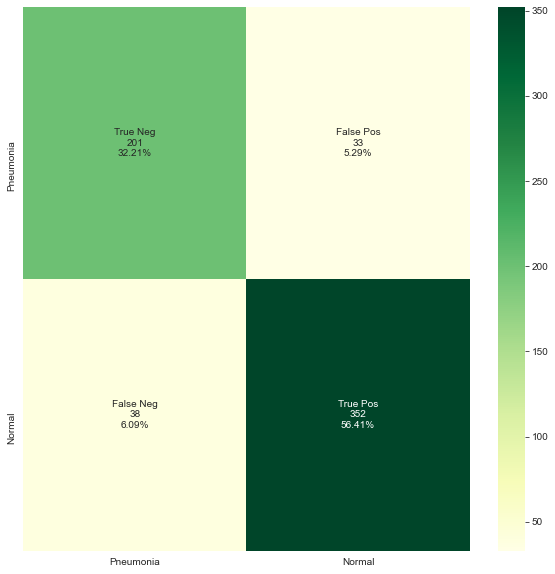

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
xticklabels = classes,yticklabels = classes)


## Transfer Learning using InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3


In [ ]:
# Notice 1st time this is being run, it will download the weights for the ResNet model
tf.keras.backend.clear_session()

base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False


In [ ]:
def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    x = base_model(inputs)
    
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model



In [ ]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
    ,optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
                         metrics='binary_accuracy')
model_pretrained.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = 
                                               batch_size),
epochs = n_epochs , validation_data = datagen.flow(x_val,y_val),
callbacks = [learning_rate_reduction],
steps_per_epoch = x_train.shape[0]/batch_size,
class_weight = class_weight)


Epoch 1/25
130/130 [==============================] - 31s 210ms/step - loss: 0.5381 - binary_accuracy: 0.7550 - val_loss: 0.3692 - val_binary_accuracy: 0.8477 - lr: 5.0000e-05
Epoch 2/25
130/130 [==============================] - 26s 196ms/step - loss: 0.3493 - binary_accuracy: 0.8447 - val_loss: 0.3438 - val_binary_accuracy: 0.8602 - lr: 5.0000e-05
Epoch 3/25
130/130 [==============================] - 26s 196ms/step - loss: 0.3385 - binary_accuracy: 0.8545 - val_loss: 0.3828 - val_binary_accuracy: 0.8400 - lr: 5.0000e-05
Epoch 4/25
130/130 [==============================] - 26s 197ms/step - loss: 0.3049 - binary_accuracy: 0.8799 - val_loss: 0.2772 - val_binary_accuracy: 0.8831 - lr: 5.0000e-05
Epoch 5/25
130/130 [==============================] - 26s 197ms/step - loss: 0.2746 - binary_accuracy: 0.8821 - val_loss: 0.3340 - val_binary_accuracy: 0.8592 - lr: 5.0000e-05
Epoch 6/25
130/130 [==============================] - 26s 197ms/step - loss: 0.2646 - binary_accuracy: 0.8921 - val_loss

130/130 [==============================] - 26s 197ms/step - loss: 0.2073 - binary_accuracy: 0.9123 - val_loss: 0.2627 - val_binary_accuracy: 0.8956 - lr: 5.0000e-05
Epoch 20/25
130/130 [==============================] - 26s 197ms/step - loss: 0.2093 - binary_accuracy: 0.9084 - val_loss: 0.2247 - val_binary_accuracy: 0.9186 - lr: 5.0000e-05
Epoch 21/25
130/130 [==============================] - 26s 198ms/step - loss: 0.2351 - binary_accuracy: 0.9027 - val_loss: 0.3337 - val_binary_accuracy: 0.8697 - lr: 5.0000e-05
Epoch 22/25
130/130 [==============================] - 26s 197ms/step - loss: 0.2145 - binary_accuracy: 0.9060 - val_loss: 0.2234 - val_binary_accuracy: 0.9061 - lr: 5.0000e-05
Epoch 23/25
130/130 [==============================] - 26s 197ms/step - loss: 0.2205 - binary_accuracy: 0.9094 - val_loss: 0.2277 - val_binary_accuracy: 0.9004 - lr: 5.0000e-05
Epoch 24/25
130/130 [==============================] - 26s 197ms/step - loss: 0.2030 - binary_accuracy: 0.9171 - val_loss: 0.19

## Results from InceptionV3

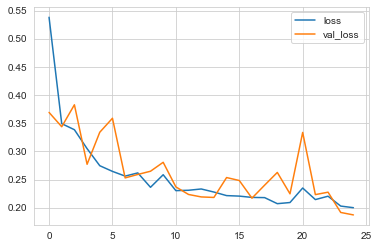

In [ ]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()


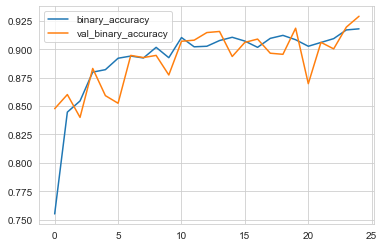

In [ ]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")


20/20 [==============================] - 4s 143ms/step - loss: 0.3636 - binary_accuracy: 0.8622
Loss of the model is -  0.3636183738708496
20/20 [==============================] - 3s 142ms/step - loss: 0.3636 - binary_accuracy: 0.8622
Accuracy of the model is -  86.21794581413269 %


In [ ]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

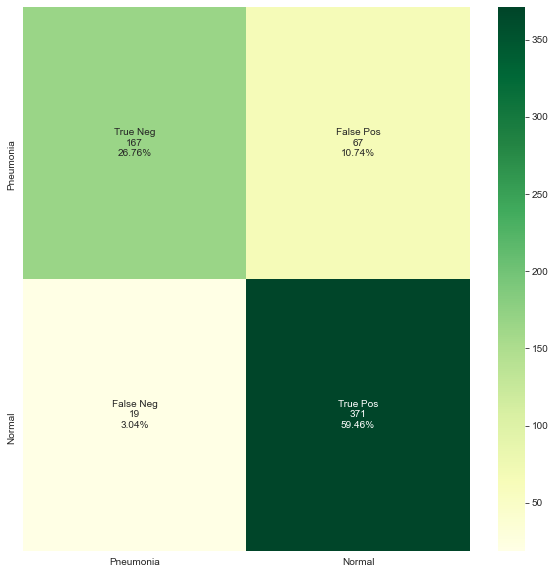

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
        cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
        cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
        xticklabels = classes,yticklabels = classes)


In [ ]:
cf_matrix

array([[167,  67],
       [ 19, 371]], dtype=int64)

## Fine Tuning InceptionV3

In [ ]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
model_pretrained.compile(loss='binary_crossentropy'
,optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002),metrics='binary_accuracy')
model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
epochs = n_epochs , validation_data = datagen.flow(x_val,y_val) ,
callbacks = [learning_rate_reduction],
steps_per_epoch = x_train.shape[0]/batch_size,
class_weight = class_weight)

Epoch 1/25
130/130 [==============================] - 30s 200ms/step - loss: 0.2090 - binary_accuracy: 0.9240 - val_loss: 0.2272 - val_binary_accuracy: 0.9215 - lr: 2.0000e-06
Epoch 2/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2167 - binary_accuracy: 0.9135 - val_loss: 0.2234 - val_binary_accuracy: 0.9013 - lr: 2.0000e-06
Epoch 3/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2111 - binary_accuracy: 0.9137 - val_loss: 0.2419 - val_binary_accuracy: 0.9061 - lr: 2.0000e-06
Epoch 4/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2006 - binary_accuracy: 0.9137 - val_loss: 0.2319 - val_binary_accuracy: 0.9148 - lr: 2.0000e-06
Epoch 5/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2066 - binary_accuracy: 0.9178 - val_loss: 0.2224 - val_binary_accuracy: 0.9061 - lr: 2.0000e-06
Epoch 6/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2121 - binary_accuracy: 0.9154 - val_loss

130/130 [==============================] - 25s 191ms/step - loss: 0.2120 - binary_accuracy: 0.9130 - val_loss: 0.2148 - val_binary_accuracy: 0.9176 - lr: 2.0000e-06
Epoch 20/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2067 - binary_accuracy: 0.9140 - val_loss: 0.2222 - val_binary_accuracy: 0.9138 - lr: 2.0000e-06
Epoch 21/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2033 - binary_accuracy: 0.9151 - val_loss: 0.2099 - val_binary_accuracy: 0.9205 - lr: 2.0000e-06
Epoch 22/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2045 - binary_accuracy: 0.9132 - val_loss: 0.2279 - val_binary_accuracy: 0.9205 - lr: 2.0000e-06
Epoch 23/25
130/130 [==============================] - 25s 191ms/step - loss: 0.2185 - binary_accuracy: 0.9082 - val_loss: 0.2274 - val_binary_accuracy: 0.9071 - lr: 2.0000e-06
Epoch 24/25
130/130 [==============================] - 25s 192ms/step - loss: 0.1964 - binary_accuracy: 0.9207 - val_loss: 0.21

## Results from Fine Tuning InceptionV3

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")


20/20 [==============================] - 4s 153ms/step - loss: 0.3285 - binary_accuracy: 0.8766
Loss of the model is -  0.3285255432128906
20/20 [==============================] - 3s 143ms/step - loss: 0.3285 - binary_accuracy: 0.8766
Accuracy of the model is -  87.66025900840759 %


In [ ]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

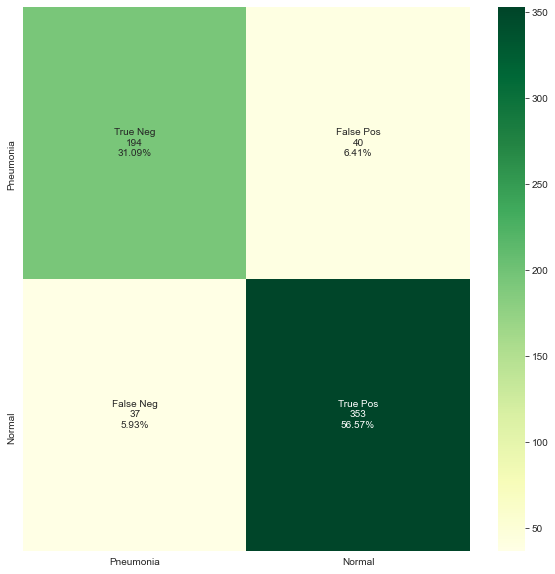

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
xticklabels = classes,yticklabels = classes)


## Results From all Models

- CNN Base Model = 86.0 %
- InceptionV3 = 86.2 %
- Fine Tuning InceptionV3 = 87.7 %
- ResNet152V2 = 88.1 %
- Fine Tuning ResNet152V2 = 88.6 %

## Conclusion & Future Direction


The project shown above was an evaluation/ test of different kinds of models for the identification of pneumonia, trained on chest X-ray images. In the data pre-processing section there was not enough data in the validation set. This problem was solved by splitting the entire training dataset into both training and validation, where 80% of the training set was used for the new training set, and the remaining 20% was used for the validation set. I used the method ‘stratify’ in order to maintain the ratio of positive to negative diagnosis results. The ratios have been presented in a visualisation to prove the ratios are staying consistent. The image size used for the images was 124X124. This is not only due to the ram requirements being too high for my machine when ran at 224X224, but from research done on image size affecting model performance states that when using a dataset that Is smaller than an ‘ImageNet’ scale network can benefit from a smaller image size. Each model was run with the batch size of 32, for 25 epochs. The function ‘ReduceLROnPlateau’ was used when training the models in order to change the learning rates throughout training. 
From the results collected the best performing model for Accuracy was ResNet152V2 after fine tuning, with an accuracy score of 88.6% 
For future work drawing parallels to the research reviewed in section one. Developing an algorithm which can localize specific parts of the lung that have been affected by pneumonia would be a great help to not only identify the diagnosis of pneumonia, but also can display the problem areas in urgent need of care. 
